In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open3d as o3d
import numpy as np
from pipeline import *
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
ct_path = "./data/2/"

In [4]:
# read files
us_pcd = np.asarray(o3d.io.read_point_cloud("./data/us_pcd.ply").points)
us_pointset = np.load("./data/us_pointset.npy")
ct_pcd = np.asarray(o3d.io.read_point_cloud(ct_path + "surface.ply").points)
ct_pointset = np.load(ct_path + "ct_pointset.npy")

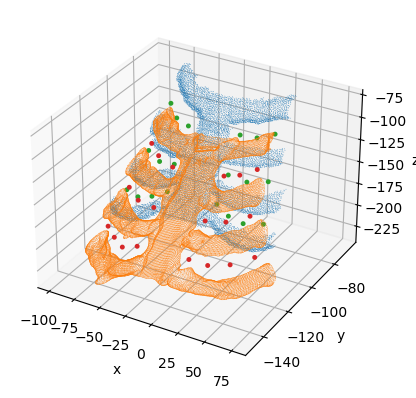

In [5]:
vis_pcd([us_pcd, ct_pcd, us_pointset, ct_pointset], point_size=[1, 0.5, 50, 50])
# orange: ct points
# blue: us points

## Coarse registration

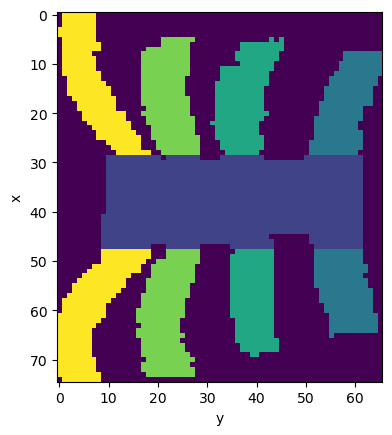

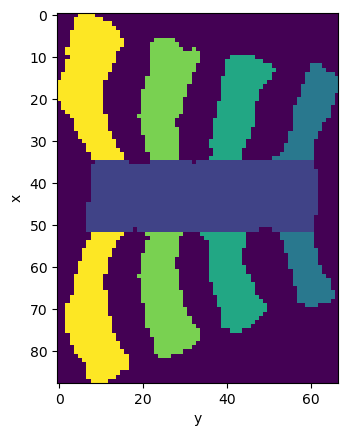

In [6]:
labels_us, axises3D_us, translation_us = initialization(us_pcd, 30, 90)
labels_ct, axises3D_ct, translation_ct = initialization(ct_pcd, 30, 90)

In [7]:
us_pcd_init = (axises3D_us @ (us_pcd + translation_us).T).T
us_pointset_init = (axises3D_us @ (us_pointset + translation_us).T).T
ct_pcd_init = (axises3D_ct @ (ct_pcd + translation_ct).T).T
ct_pointset_init = (axises3D_ct @ (ct_pointset + translation_ct).T).T

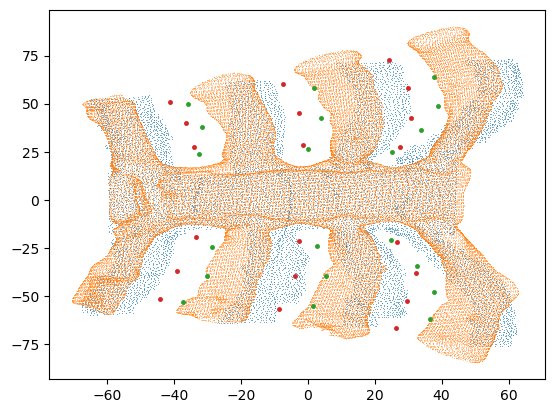

In [8]:
vis_scatter([us_pcd_init, ct_pcd_init, us_pointset_init, ct_pointset_init], point_size=[1, 0.5, 50, 50])
# blue: utrasound
# orange: ct

## Fine registration

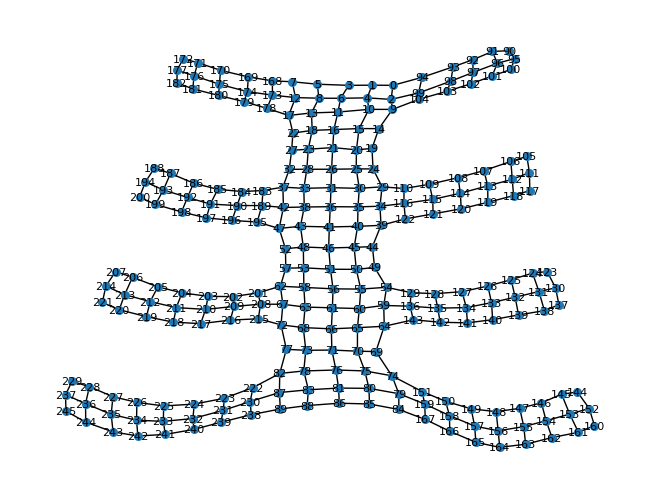

In [9]:
# Graph SOM for the CT pcd
graph_ct = cal_ct_graph(ct_pcd_init, ct_pcd_init[labels_ct == 1])
vis_graph(graph_ct)

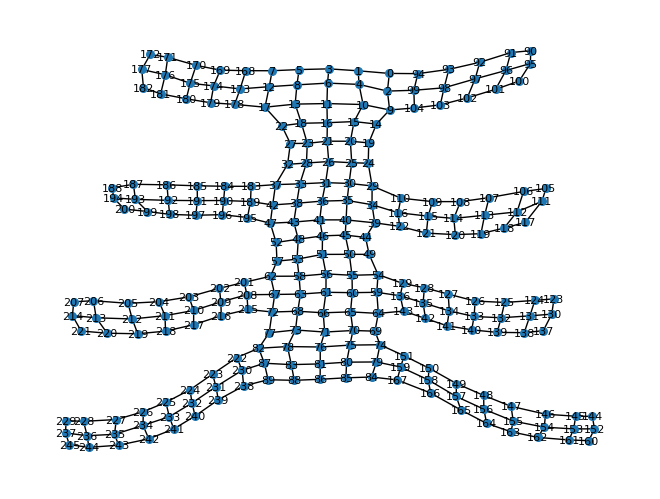

In [10]:
# Graph SOM for the US pcd
graph_us = cal_us_graph(us_pcd_init, graph_ct)
vis_graph(graph_us)

In [11]:
# Registration
graph_ct = compute_Rt(graph_ct, graph_us, 3)
ct_pcd_trans = tramsform_pcd(ct_pcd_init, graph_ct, 3)

In [12]:
# Translate points from CT to US
ct_pointset_trans = transform_points(ct_pointset_init, ct_pcd_init, ct_pcd_trans, r=20)

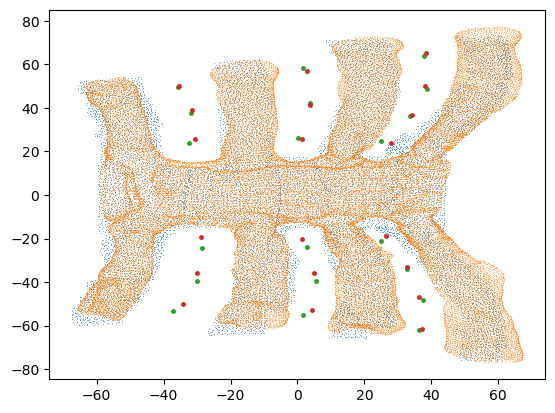

In [13]:
vis_scatter([us_pcd_init, ct_pcd_trans, us_pointset_init, ct_pointset_trans], point_size=[1, 0.5, 50, 50])
# blue: utrasound
# orange: ct after transformation

In [14]:
print(f"Hausdorff distance: {cal_hausdorff_distance(us_pcd_init, ct_pcd_trans).max()}")

Hausdorff distance: 8.177442495969292


In [15]:
l2_distance = np.linalg.norm(us_pointset_init - ct_pointset_trans, axis=1)
print(f"path transferring error\nMean: {l2_distance.mean()}.\nSD: {l2_distance.std()}")

path transferring error
Mean: 2.3792897524746146.
SD: 1.3565170067787833
